In [1]:
import numpy as np
import pandas as pd
import method_self
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

In [2]:
# 有关估计缺失值k的参数图

# 一些参数设定
sigma2 = 0.2 # 对比实验2中的灰色聚类方法，最后的参数设定
# 参数设置
sigma = 1 # 选择初始聚类中心时候标准差前面的系数
alpha = 0.5 # 计算相互影响力时候，控制调整成本的影响的参数
beta = 0 # 计算不可变度时，控制调整成本的参数
gamma = 0.5 # 计算不可变度时，控制信任度的参数
lammda = 0.5 # 边界域和负域的划分比
epsilon = 0.02 # 允许修改的最大量
theta_ideal = 0.9 # 理想的共识度
xi = 1
knn_k = 5 # 通过main1实验分析得到的knn参数

In [3]:
# 先读取数据
IFPR_pd = pd.read_excel('incomplete_data.xlsx', header=None)
T_pd = pd.read_excel('trust.xlsx', header=None)
p = 20
n = 5
IFPR = np.array(IFPR_pd).reshape(p, n, n)
T = np.array(T_pd)
IFPR[IFPR == '~'] = np.nan
IFPR = np.array(IFPR, dtype=float)
np.random.seed(42)
AC = np.random.rand(p)
AC= np.round(AC, 2)
print(AC)

[0.37 0.95 0.73 0.6  0.16 0.16 0.06 0.87 0.6  0.71 0.02 0.97 0.83 0.21
 0.18 0.18 0.3  0.52 0.43 0.29]


# 第一部分 参数$k$的图

In [4]:
psi = np.ones(p)/p
CD_incomplete = method_self.calculate_in_CD(IFPR, psi)
knn_k_set = np.arange(2,11,1)
CD_set = np.zeros(len(knn_k_set))
CD1 = np.ones(len(knn_k_set))*CD_incomplete
for i in range(len(knn_k_set)):
    FPR = method_self.estimate(IFPR, T, knn_k_set[i])
    CD_set[i] = method_self.calculate_in_CD(FPR, psi)

In [5]:
FPR_set_k = np.zeros((len(knn_k_set), p, n, n))
clusters=[]
clusters_index = np.ones((len(knn_k_set), p), dtype=int)
for i in range(len(knn_k_set)):
    FPR_set_k[i] = method_self.estimate(IFPR, T, knn_k_set[i])
    centroids = method_self.initial_centroid(T, 1)
    cluster = method_self.im_kmeans(FPR_set_k[i], T, centroids, AC, 0.5)
    clusters.append(cluster)
    for j in range(len(cluster)):
        clusters_index[i][cluster[j]] = j

#5861AC 紫色
#2878B5 流程图之间的箭头 蓝色
#C82423 红色
#5086C4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


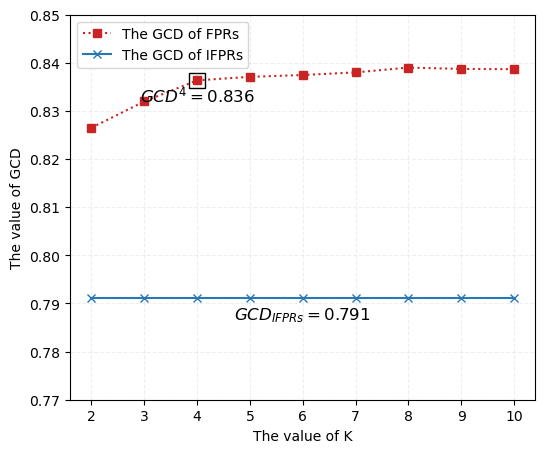

In [6]:
# 创建图形:CD_k
plt.figure(figsize=(6, 5))
import matplotlib.patches as patches
plt.plot(knn_k_set, CD_set, marker='s', color='#C82423', linestyle=':', linewidth=1.5, markersize=6, label='The GCD of FPRs')
plt.plot(knn_k_set, CD1, marker='x', color='#2878B5', linestyle='-', linewidth=1.5, markersize=6, label='The GCD of IFPRs')
highlight_box = patches.Rectangle((knn_k_set[2]-0.15, CD_set[2]-0.0015), 0.3, 0.003, linestyle='-', linewidth=1, edgecolor='black', facecolor='none')
plt.gca().add_patch(highlight_box)
plt.ylim(0.77, 0.85)


# 注释关键点
plt.annotate('$GCD_{IFPRs}=0.791$', (knn_k_set[4], CD1[4]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=12)
plt.annotate('$GCD^{4}=0.836$', (knn_k_set[2], CD_set[2]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=12)
# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.xlabel('The value of K')
plt.ylabel('The value of GCD')

plt.savefig('CD_k.eps', format='eps')

plt.show()

In [7]:
def cluster_SC(FPR, cluster_index, T, AC):
    p = len(FPR)
    DM_index = np.arange(0,p,1)
    SC_i = np.zeros(p)
    for i in range(p):
        SC_i_a = 0 #某个样本与其所在簇内其他样本的平均距离
        SC_i_b = 0 #某个样本与其他簇样本的平均距离
        index = cluster_index[i]
        p_cluster_num = np.sum(cluster_index==index)
        p_non_cluster_num = p - p_cluster_num
        DM_cluster_index = DM_index[cluster_index==index]
        DM_noncluster_index = DM_index[cluster_index!=index]
        for j in range(p_cluster_num):
            if DM_cluster_index[j] != i:
                DM1 = [i]
                DM2 = [DM_cluster_index[j]]
                MI = method_self.calulate_MI(FPR, T, DM1, DM2)
                SC_i_a = (1- MI + np.abs(AC[i]-AC[DM_cluster_index[j]]))/2 + SC_i_a
        if p_cluster_num == 1:
            SC_i_a = 0
        else:
            SC_i_a = SC_i_a / (p_cluster_num-1)
        for j in range(p_non_cluster_num):
            DM1 = [i]
            DM2 = [DM_noncluster_index[j]]
            MI = method_self.calulate_MI(FPR, T, DM1, DM2)
            SC_i_b = (1- MI + np.abs(AC[i]-AC[DM_noncluster_index[j]]))/2 + SC_i_b
        SC_i_b = SC_i_b / p_non_cluster_num
        
        SC_i[i] = (SC_i_b-SC_i_a)/max(SC_i_a, SC_i_b)
    SC = np.mean(SC_i)
    return SC

def cluster_Dunn(FPR, cluster_index, T, AC):
    p = len(FPR)
    DM_index = np.arange(0,p,1)
    c = np.max(cluster_index)+1
    max_d = np.zeros(c) # 记录类内的最大距离
    min_d = 100
    for i in range(c):
        DM_current_index = DM_index[cluster_index == i]
        if len(DM_current_index) != 1:
            for j in range(len(DM_current_index)):
                for k in range(len(DM_current_index)):
                    if j !=k :
                        DM1 = [DM_current_index[j]]
                        DM2 = [DM_current_index[k]]
                        MI = method_self.calulate_MI(FPR, T, DM1, DM2)
                        dis = (1 - MI + np.abs(AC[DM_current_index[j]]-AC[DM_current_index[k]]))/2
                        if dis> max_d[i]:
                            max_d[i] = dis
    for i in range(c-1):
        DM_current_index = DM_index[cluster_index == i]
        for j in range(i+1,c):
            DM2 = DM_index[cluster_index == j]
            MI = method_self.calulate_MI(FPR, T, DM_current_index, DM2)
            AC_group1 = np.mean(AC[DM_current_index])
            AC_group2 = np.mean(AC[DM2])
            dis = (1- MI + np.abs(AC_group1 - AC_group2))/2
            if dis < min_d:
                min_d = dis
    Dunn = min_d / np.max(max_d)
    return Dunn

def cluster_DB(FPR, cluster_index, cluster_result, T, AC):
    p = len(FPR)
    DM_index = np.arange(0,p,1)
    c = len(cluster_result)
    DB_i = np.zeros(c)
    sigma_i = np.zeros(c)
    center_index = np.zeros(c, dtype=int)
    for i in range(c):
        DM_i_index = DM_index[cluster_index == i]
        center_index[i] = cluster_result[i][0]
        if len(DM_i_index)==1:
            sigma_i[i] = 0
        else:
            for j in range(len(DM_i_index)):
                DM1 = [DM_i_index[j]]
                DM2 = [center_index[i]]
                MI = method_self.calulate_MI(FPR, T, DM1, DM2)
                dis = (1-MI + np.abs(AC[DM_i_index[j]]-AC[center_index[i]]))/2
                sigma_i[i] = sigma_i[i] + dis
            sigma_i[i] = sigma_i[i]/len(DM_i_index)
    for i in range(c):
        for j in range(c):
            if i != j :
                DM1 = [center_index[i]]
                DM2 = [center_index[j]]
                MI = method_self.calulate_MI(FPR, T, DM1, DM2)
                dis = (1-MI+np.abs(AC[center_index[i]] - AC[center_index[j]]))/2
                d = (sigma_i[i]+sigma_i[j])/dis
                if d>DB_i[i]:
                    DB_i[i] = d
    DB = np.mean(DB_i)
    return DB

In [8]:
SC_5 = cluster_SC(FPR_set_k[2], clusters_index[2], T, AC)
Dunn_5 = cluster_Dunn(FPR_set_k[2], clusters_index[2], T, AC)
DB_5 = cluster_DB(FPR_set_k[2], clusters_index[2], clusters[2], T, AC)

In [9]:
print(SC_5)
print(Dunn_5)
print(DB_5)

0.265739185214537
0.5975699643197495
1.3034233567007962


In [10]:
SC_set = np.zeros(len(knn_k_set))
Dunn_set = np.zeros(len(knn_k_set))
DB_set = np.zeros(len(knn_k_set))
for i in range(len(knn_k_set)):
    SC_set[i] = cluster_SC(FPR_set_k[i], clusters_index[i], T, AC)
    Dunn_set[i] = cluster_Dunn(FPR_set_k[i], clusters_index[i], T, AC)
    DB_set[i] = cluster_DB(FPR_set_k[i], clusters_index[i], clusters[i], T, AC)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


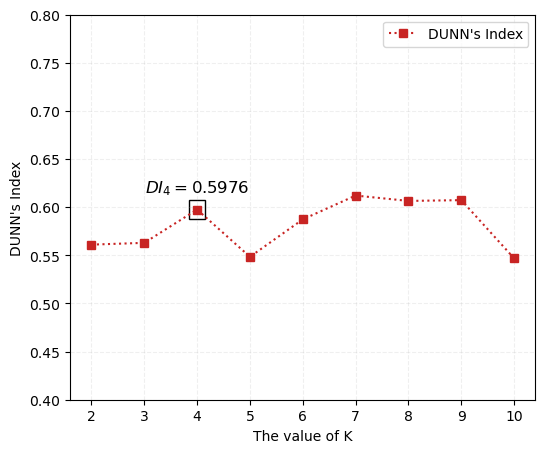

In [11]:
# 画图
# 创建图形:CD_k
plt.figure(figsize=(6, 5))

plt.plot(knn_k_set, Dunn_set, marker='s', color='#C82423', linestyle=':', linewidth=1.5, markersize=6, label='DUNN\'s Index')
highlight_box = patches.Rectangle((knn_k_set[2]-0.15, Dunn_set[2]-0.01), 0.3, 0.02, linestyle='-', linewidth=1, edgecolor='black', facecolor='none')
plt.gca().add_patch(highlight_box)
plt.ylim(0.4, 0.8)
# 添加图例
plt.legend()
# 增加网格线
# 注释关键点
plt.annotate('$DI_{4} = 0.5976$', (knn_k_set[2], Dunn_set[2]), textcoords="offset points", xytext=(0,12), ha='center', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.2)

plt.xlabel('The value of K')
plt.ylabel('DUNN\'s Index')

plt.savefig('k1.eps', format='eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


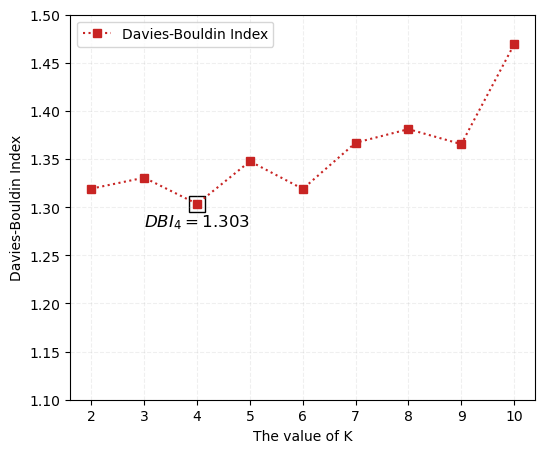

In [12]:
# 画图
# 创建图形:CD_k
import matplotlib.patches as patches
plt.figure(figsize=(6, 5))

plt.plot(knn_k_set, DB_set, marker='s', color='#C82423', linestyle=':', linewidth=1.5, markersize=6, label='Davies-Bouldin Index')
highlight_box = patches.Rectangle((knn_k_set[2]-0.15, DB_set[2]-0.008), 0.3, 0.016, linestyle='-', linewidth=1, edgecolor='black', facecolor='none')
plt.gca().add_patch(highlight_box)

plt.ylim(1.1, 1.5)
# 添加图例
plt.legend()
# 注释关键点
plt.annotate('$DBI_{4} = 1.303$', (knn_k_set[2], DB_set[2]), textcoords="offset points", xytext=(0,-16), ha='center', fontsize=12)

# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.xlabel('The value of K')
plt.ylabel('Davies-Bouldin Index')

plt.savefig('k2.eps', format='eps')

plt.show()

# 第二部分 参数$\beta$的图

In [13]:
# 参数设置
sigma = 1 # 选择初始聚类中心时候标准差前面的系数
alpha = 0.5 # 计算相互影响力时候，控制调整成本的影响的参数
beta = 0 # 计算不可变度时，控制调整成本的参数
gamma = 0.5 # 计算不可变度时，控制信任度的参数
lammda = 0.5 # 边界域和负域的划分比
epsilon = 0.02 # 允许修改的最大量
theta_ideal = 0.9 # 理想的共识度
xi = 0
knn_k = 5 # 通过main1实验分析得到的knn参数
# 先读取数据
IFPR_pd = pd.read_excel('incomplete_data.xlsx', header=None)
T_pd = pd.read_excel('trust.xlsx', header=None)
p = 20
n = 5
IFPR = np.array(IFPR_pd).reshape(p, n, n)
T = np.array(T_pd)
IFPR[IFPR == '~'] = np.nan
IFPR = np.array(IFPR, dtype=float)
AC1 = np.ones(p)
np.random.seed(42)
AC2 = np.random.rand(p)
AC2 = np.round(AC2, 2)
print(AC2)
AC1 = np.mean(AC2)*AC1

[0.37 0.95 0.73 0.6  0.16 0.16 0.06 0.87 0.6  0.71 0.02 0.97 0.83 0.21
 0.18 0.18 0.3  0.52 0.43 0.29]


In [14]:
# 该函数用于计算第一阶段的调整成本
def calculate_cost1(fpr, fpr_new, AC):

    cost = AC @ np.sum(np.sum(np.abs(fpr - fpr_new), axis=1), axis=1)
    return cost
def calculate_AC_group(AC, cluster):
    AC_group = np.zeros(len(cluster))
    for i in range(len(cluster)):
        AC_group[i] = np.mean(AC[cluster[i]])
        
    return AC_group
# 画有关参数beta的图
beta_set = np.arange(0, 0.8, 0.1)
FPR = method_self.estimate(IFPR, T, 5)
centroids = method_self.initial_centroid(T, sigma)
current_cluster2 = method_self.im_kmeans(FPR, T, centroids, AC2, 1)
current_cluster1 = method_self.im_kmeans(FPR, T, centroids, AC1, 1)
num = len(beta_set)
cost1 = np.zeros(num)
cost1_compare = np.zeros(num)
cost2 = np.zeros(num)
cost2_compare = np.zeros(num)
for i in range(num):
    FPR_new, center_new, CD, FPR, FPR_end, center1, T_1, T1 = method_self.all_progress(IFPR, T, 5, AC2, 1, beta_set[i], (1-beta_set[i])/2,
                                                                                theta_ideal, lammda, epsilon, xi, sigma)
    cost1[i] = calculate_cost1(FPR, FPR_end, AC2)
    AC_group = calculate_AC_group(AC2, current_cluster2)
    cost2[i] = calculate_cost1(center1, center_new, AC_group)
    FPR_new, center_new, CD, FPR, FPR_end, center1, T_1, T1 = method_self.all_progress(IFPR, T, 5, AC1, 1, beta_set[i], (1-beta_set[i])/2,
                                                                                theta_ideal, lammda, epsilon, xi, sigma)
    cost1_compare[i] = calculate_cost1(FPR, FPR_end, AC1)
    AC_group = calculate_AC_group(AC1, current_cluster1)
    cost2_compare[i] = calculate_cost1(center1, center_new, AC_group)
cost = cost1 + cost2
cost_compare = cost1_compare + cost2_compare

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


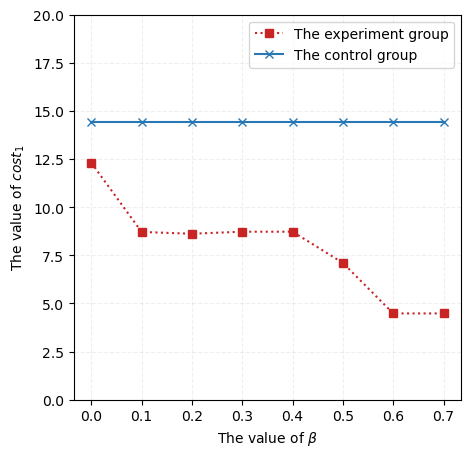

In [15]:
# 创建图形:CD_k
plt.figure(figsize=(5, 5))

plt.plot(beta_set, cost1, marker='s', color='#C82423', linestyle=':', linewidth=1.5, markersize=6, label='The experiment group')
plt.plot(beta_set, cost1_compare, marker='x', color='#2878B5', linestyle='-', linewidth=1.5, markersize=6, label='The control group')

plt.ylim(0, 20)
# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.xlabel('The value of $\\beta$')
plt.ylabel('The value of $cost_{1}$')

plt.savefig('beta1.eps', format='eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


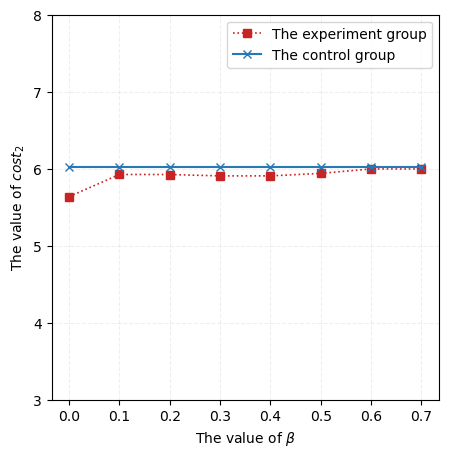

In [16]:
# 创建图形:CD_k
plt.figure(figsize=(5, 5))

plt.plot(beta_set, cost2, marker='s', color='#C82423', linestyle=':', linewidth=1.2, markersize=6, label='The experiment group')
plt.plot(beta_set, cost2_compare, marker='x', color='#2878B5', linestyle='-', linewidth=1.5, markersize=6, label='The control group')

plt.ylim(3, 8)
# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.xlabel('The value of $\\beta$')
plt.ylabel('The value of $cost_{2}$')

plt.savefig('beta2.eps', format='eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


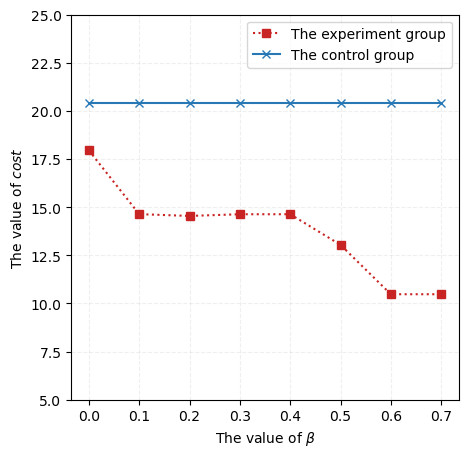

In [17]:
# 创建图形:CD_k
plt.figure(figsize=(5, 5))

plt.plot(beta_set, cost, marker='s', color='#C82423', linestyle=':', linewidth=1.5, markersize=6, label='The experiment group')
plt.plot(beta_set, cost_compare, marker='x', color='#2878B5', linestyle='-', linewidth=1.5, markersize=6, label='The control group')

plt.ylim(5,25)
# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)


plt.xlabel('The value of $\\beta$')
plt.ylabel('The value of $cost$')

plt.savefig('beta3.eps', format='eps')

plt.show()

# 第三部分 优化过程的参数寻优

In [18]:
# 重新写一个函数记录迭代次数的函数
from scipy.optimize import minimize
def consensus_reach_dynamic1(FPR, DM, T, AC, beta, gamma, psi, theta_ideal, lammda, epsilon, xi):
    """
    函数旨在达成共识
    :param FPR:一组模糊偏好关系；在第一阶段为组内，第二阶段为各个组的类中心模糊偏好关系
    :param T: 社区信任网络
    :param AC: 单位调整成本
    :param beta: 单位调整成本的控制参数
    :param gamma:信任度的控制参数
    :param psi:各个决策者的权重，在第一阶段每个决策者的权重相等，第二阶段根据子组大小确定
    :return:达成共识的结果
    """
    iter_record = 0
    
    # 先根据权重计算类中心
    p = len(psi)
    n = FPR[0].shape[0]
    Psi = np.repeat(np.repeat(psi, n, axis=0).reshape(p, n), n, axis=0).reshape(p, n, n)
    center = np.sum(Psi * FPR, axis=0)
    T1 = T.copy()
    # 根据权重计算共识度
    CD = method_self.calculate_CD(FPR, psi)
    center_new = center.copy()
    FPR_new = FPR.copy()
    # 当共识未达到阈值时
    iter = 0
    while CD < theta_ideal:

        # 计算正域及相关信任度
        Pos = method_self.calculate_pos(FPR_new, center_new, theta_ideal)
        DM1 = np.array(DM)
        if Pos[0] == -1:
            DM_remain = DM1
            Pos_T = np.zeros((len(DM_remain), len(Pos)))
            Pos_T[:, 0] = np.mean(T1[DM][:, DM])
            Pos_FPR = center_new.reshape(1, n, n)
        else:
            DM_remain = np.array(list(set(DM) - set(DM1[Pos])))
            Pos_T = T1[DM_remain][:, Pos]
            if len(Pos) == 1:
                Pos_FPR = FPR_new[Pos].reshape(1, n, n)
            else:
                Pos_FPR = FPR_new[Pos]
        # 计算不可变度
        DM_remain_index = np.array(list(set(np.arange(0, len(DM), 1)) - set(Pos)))
        VD = method_self.calculate_VD(DM_remain, Pos_T, AC, FPR_new, center_new, beta, gamma, DM_remain_index)
        VD_lammda = np.min(VD) + lammda * (np.max(VD) - np.min(VD))
        # 计算边界域和负域的决策者
        Bon = DM_remain[VD <= VD_lammda]


        # 约束条件
        Bon_index = []
        Bon_index1 = []
        for i in range(len(Bon)):
            Bon_index.append(list(np.where(DM == Bon[i])[0]))
            Bon_index1.append(list(np.where(DM_remain == Bon[i])[0]))
        Bon_index = np.array(Bon_index).reshape(-1)
        Bon_index1 = np.array(Bon_index1).reshape(-1)
        p1 = len(Bon)
        Pos_T1 = Pos_T[Bon_index1] / np.sum(Pos_T[Bon_index1], axis=1).reshape(p1, 1)
        F1 = FPR_new[Bon_index]
        p2 = len(Pos)
        for i in range(p1):
            matrix = np.repeat(np.repeat(Pos_T1[i], n, axis=0).reshape(p2, n), n, axis=0).reshape(p2, n, n)
            F1[i] = np.sum(matrix * Pos_FPR, axis=0)
        F1_flat = F1.reshape(-1)
        constraint = {'type': 'ineq', 'fun': lambda F: np.abs(F-F1_flat)-epsilon}

        # 设定初始值
        initial_guess = F1_flat

        result = minimize(objectfun, initial_guess, args=(FPR_new, AC, xi, psi, Bon, Bon_index), constraints=constraint)
        FPR_new[Bon_index] = result.x.reshape(p1, n, n)

        center_new = np.sum(Psi * FPR_new, axis=0)

        
        # 动态更新信任度
        if Pos[0] == -1:
            continue
        for i in range(p1):
            for j in range(p2):
                T1[Bon_index[i], Pos[j]] = np.power(T1[Bon_index[i], Pos[j]], (1-T1[Bon_index[i], Pos[j]]))
        # 此外，还得更新负域中决策者对边界域中决策者的信任度
        Neg_index = np.array(list(set(np.arange(0, len(DM), 1)) - set(Pos) - set(Bon_index)))
        for i in range(len(Neg_index)):
            for j in range(p1):
                T1[Neg_index[i], Bon_index[j]] = np.power(T1[Neg_index[i], Bon_index[j]], 1-np.mean(T1[Neg_index[i], Pos]))
        
        # 根据权重计算共识度
        CD = calculate_CD(FPR_new, psi)
        iter_record = iter_record + 1
        iter = iter + 1
        if iter >= maxiter:
            break

    T = T1
    return FPR_new, center_new, CD, T, iter_record
def all_progress1(IFPR, T, knn_k, AC, alpha, beta, gamma, theta_ideal, lammda, epsilon, xi, sigma, maxiter):

    iter_all_record = 0
    FPR = method_self.estimate(IFPR, T, knn_k)
    p = len(FPR)
    n = FPR[0].shape[0]
    FPR_end = np.zeros((p, n, n))
    initial_centroids = method_self.initial_centroid(T, sigma)
    cluster_result = method_self.im_kmeans(FPR, T, initial_centroids, AC, alpha)

    FPR1 = []
    for i in range(len(cluster_result)):
        FPR1.append([])
        FPR1[i].append(FPR[cluster_result[i]])
    FPR1_new = FPR1.copy()
    center1 = np.ones((len(cluster_result), n, n))
    T_1 = T.copy()
    # 第一阶段的共识达成
    for i in range(len(cluster_result)):
        psi = np.ones(len(cluster_result[i])) / len(cluster_result[i])
        p1 = len(cluster_result[i])
        FPR1_new[i][0], _, CD_, T_1, iter_record = consensus_reach_dynamic1(FPR1[i][0], cluster_result[i], T_1, AC, beta, gamma, psi, theta_ideal,
                                                   lammda,
                                                   epsilon, xi, maxiter)
        iter_all_record = iter_all_record + iter_record
        FPR_end[cluster_result[i]] = FPR1_new[i][0]
        Psi = np.repeat(np.repeat(psi, n, axis=0).reshape(p1, n), n, axis=0).reshape(p1, n, n)
        center1[i] = np.sum(Psi * FPR1_new[i][0], axis=0)
    # 第二阶段的共识达成
    psi = np.ones(len(cluster_result))
    AC1 = np.ones(len(cluster_result))
    T1 = np.ones((len(cluster_result), len(cluster_result)))
    for i in range(len(cluster_result)):
        psi[i] = len(cluster_result[i]) / p
        AC1[i] = np.mean(AC[cluster_result[i]])
        for j in range(len(cluster_result)):
            if i == j:
                T1[i, j] = 1
            else:
                T1[i, j] = np.mean(T_1[cluster_result[i]][:, cluster_result[j]])
    new_cluster = np.arange(0, len(cluster_result), 1)

    center1_new, Center, CD, T1, iter_record = consensus_reach_dynamic1(center1, new_cluster, T1, AC1, beta, gamma, psi, theta_ideal, lammda,
                                            epsilon, xi, maxiter)
    iter_all_record = iter_all_record + iter_record
    return center1_new, Center, CD, FPR, FPR_end, center1, T1, T_1, iter_all_record

In [19]:
# 重新写一个函数记录迭代次数的函数
from scipy.optimize import minimize
def consensus_reach_dynamic1(FPR, DM, T, AC, beta, gamma, psi, theta_ideal, lammda, epsilon, xi, itermax):
    """
    函数旨在达成共识
    :param FPR:一组模糊偏好关系；在第一阶段为组内，第二阶段为各个组的类中心模糊偏好关系
    :param T: 社区信任网络
    :param AC: 单位调整成本
    :param beta: 单位调整成本的控制参数
    :param gamma:信任度的控制参数
    :param psi:各个决策者的权重，在第一阶段每个决策者的权重相等，第二阶段根据子组大小确定
    :return:达成共识的结果
    """
    iter_record = 0
    # 先根据权重计算类中心
    p = len(psi)
    n = FPR[0].shape[0]
    Psi = np.repeat(np.repeat(psi, n, axis=0).reshape(p, n), n, axis=0).reshape(p, n, n)
    center = np.sum(Psi * FPR, axis=0)
    T1 = T.copy()
    # 根据权重计算共识度
    CD = method_self.calculate_CD(FPR, psi)
    center_new = center.copy()
    FPR_new = FPR.copy()
    # 当共识未达到阈值时
    iter = 0
    while CD < theta_ideal:

        # 计算正域及相关信任度
        Pos = method_self.calculate_pos(FPR_new, center_new, theta_ideal)
        DM1 = np.array(DM)
        if Pos[0] == -1:
            DM_remain = DM1
            Pos_T = np.zeros((len(DM_remain), len(Pos)))
            Pos_T[:, 0] = np.mean(T1[DM][:, DM])
            Pos_FPR = center_new.reshape(1, n, n)
        else:
            DM_remain = np.array(list(set(DM) - set(DM1[Pos])))
            Pos_T = T1[DM_remain][:, Pos]
            if len(Pos) == 1:
                Pos_FPR = FPR_new[Pos].reshape(1, n, n)
            else:
                Pos_FPR = FPR_new[Pos]
        # 计算不可变度
        DM_remain_index = np.array(list(set(np.arange(0, len(DM), 1)) - set(Pos)))
        VD = method_self.calculate_VD(DM_remain, Pos_T, AC, FPR_new, center_new, beta, gamma, DM_remain_index)
        VD_lammda = np.min(VD) + lammda * (np.max(VD) - np.min(VD))
        # 计算边界域和负域的决策者
        Bon = DM_remain[VD <= VD_lammda]


        # 约束条件
        Bon_index = []
        Bon_index1 = []
        for i in range(len(Bon)):
            Bon_index.append(list(np.where(DM == Bon[i])[0]))
            Bon_index1.append(list(np.where(DM_remain == Bon[i])[0]))
        Bon_index = np.array(Bon_index).reshape(-1)
        Bon_index1 = np.array(Bon_index1).reshape(-1)
        p1 = len(Bon)
        Pos_T1 = Pos_T[Bon_index1] / np.sum(Pos_T[Bon_index1], axis=1).reshape(p1, 1)
        F1 = FPR_new[Bon_index]
        p2 = len(Pos)
        for i in range(p1):
            matrix = np.repeat(np.repeat(Pos_T1[i], n, axis=0).reshape(p2, n), n, axis=0).reshape(p2, n, n)
            F1[i] = np.sum(matrix * Pos_FPR, axis=0)
        F1_flat = F1.reshape(-1)
        constraint = {'type': 'ineq', 'fun': lambda F: np.abs(F-F1_flat)-epsilon}

        # 设定初始值
        initial_guess = F1_flat

        result = minimize(method_self.objectfun, initial_guess, args=(FPR_new, AC, xi, psi, Bon, Bon_index), constraints=constraint)
        FPR_new[Bon_index] = result.x.reshape(p1, n, n)

        center_new = np.sum(Psi * FPR_new, axis=0)

        # 根据权重计算共识度
        CD = method_self.calculate_CD(FPR_new, psi)
        iter = iter + 1
        if iter >= itermax:
            break
        # 动态更新信任度
        if Pos[0] == -1:
            continue
        for i in range(p1):
            for j in range(p2):
                T1[Bon_index[i], Pos[j]] = np.power(T1[Bon_index[i], Pos[j]], (1-T1[Bon_index[i], Pos[j]]))
        # 此外，还得更新负域中决策者对边界域中决策者的信任度
        Neg_index = np.array(list(set(np.arange(0, len(DM), 1)) - set(Pos) - set(Bon_index)))
        for i in range(len(Neg_index)):
            for j in range(p1):
                T1[Neg_index[i], Bon_index[j]] = np.power(T1[Neg_index[i], Bon_index[j]], 1-np.mean(T1[Neg_index[i], Pos]))

    T = T1
    return FPR_new, center_new, CD, T, iter_record
def all_progress1(IFPR, T, knn_k, AC, alpha, beta, gamma, theta_ideal, lammda, epsilon, xi, sigma, maxiter):

    iter_all_record = 0
    FPR = method_self.estimate(IFPR, T, knn_k)
    p = len(FPR)
    n = FPR[0].shape[0]
    FPR_end = np.zeros((p, n, n))
    initial_centroids = method_self.initial_centroid(T, sigma)
    cluster_result = method_self.im_kmeans(FPR, T, initial_centroids, AC, alpha)

    FPR1 = []
    for i in range(len(cluster_result)):
        FPR1.append([])
        FPR1[i].append(FPR[cluster_result[i]])
    FPR1_new = FPR1.copy()
    center1 = np.ones((len(cluster_result), n, n))
    T_1 = T.copy()
    # 第一阶段的共识达成
    for i in range(len(cluster_result)):
        psi = np.ones(len(cluster_result[i])) / len(cluster_result[i])
        p1 = len(cluster_result[i])
        FPR1_new[i][0], _, CD_, T_1, iter_record = consensus_reach_dynamic1(FPR1[i][0], cluster_result[i], T_1, AC, beta, gamma, psi, theta_ideal,
                                                   lammda,
                                                   epsilon, xi, 100)
        iter_all_record = iter_all_record + iter_record
        FPR_end[cluster_result[i]] = FPR1_new[i][0]
        Psi = np.repeat(np.repeat(psi, n, axis=0).reshape(p1, n), n, axis=0).reshape(p1, n, n)
        center1[i] = np.sum(Psi * FPR1_new[i][0], axis=0)
    # 第二阶段的共识达成
    psi = np.ones(len(cluster_result))
    AC1 = np.ones(len(cluster_result))
    T1 = np.ones((len(cluster_result), len(cluster_result)))
    for i in range(len(cluster_result)):
        psi[i] = len(cluster_result[i]) / p
        AC1[i] = np.mean(AC[cluster_result[i]])
        for j in range(len(cluster_result)):
            if i == j:
                T1[i, j] = 1
            else:
                T1[i, j] = np.mean(T_1[cluster_result[i]][:, cluster_result[j]])
    new_cluster = np.arange(0, len(cluster_result), 1)

    center1_new, Center, CD, T1, iter_record = consensus_reach_dynamic1(center1, new_cluster, T1, AC1, beta, gamma, psi, 0.98, lammda,
                                            epsilon, xi, maxiter)
    iter_all_record = iter_all_record + iter_record
    return center1_new, Center, CD, FPR, FPR_end, center1, T1, T_1, iter_all_record

In [21]:
# 参数设置
sigma = 1 # 选择初始聚类中心时候标准差前面的系数
alpha = 0.5 # 计算相互影响力时候，控制调整成本的影响的参数
beta = 0.3 # 计算不可变度时，控制调整成本的参数
gamma = 0.5 # 计算不可变度时，控制信任度的参数
lammda = 0.5 # 边界域和负域的划分比
epsilon = 0.02 # 允许修改的最大量
theta_ideal = 0.9 # 理想的共识度
xi = 0
knn_k = 5 # 通过main1实验分析得到的knn参数
# 先读取数据
IFPR_pd = pd.read_excel('incomplete_data.xlsx', header=None)
T_pd = pd.read_excel('trust.xlsx', header=None)
#FPR_compare_pd = pd.read_excel('complete_data_compare.xlsx', header=None)
p = 20
n = 5
IFPR = np.array(IFPR_pd).reshape(p, n, n)
T = np.array(T_pd)
IFPR[IFPR == '~'] = np.nan
IFPR = np.array(IFPR, dtype=float)
np.random.seed(42)
AC = np.random.rand(p)
AC = np.round(AC, 2)
print(AC)

[0.37 0.95 0.73 0.6  0.16 0.16 0.06 0.87 0.6  0.71 0.02 0.97 0.83 0.21
 0.18 0.18 0.3  0.52 0.43 0.29]


## 先画$\xi=0$的情况

In [ ]:
iter_set = np.arange(1, 20, 1)
CD_set = np.zeros(len(iter_set))
for i in range(len(iter_set)):
    _, _, CD_set[i], _, _, _, _, _, _ = all_progress1(IFPR, T, 5, AC, 0.5, beta, (1-beta)/2,
                                                                                0.9, lammda, epsilon, 0, sigma, iter_set[i])

In [ ]:
CD_set

## 决策者数目变大

In [ ]:
import numpy as np
import pandas as pd
import method_self
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

In [ ]:
sigma = 1 # 选择初始聚类中心时候标准差前面的系数
alpha = 0.5 # 计算相互影响力时候，控制调整成本的影响的参数
beta = 0.3 # 计算不可变度时，控制调整成本的参数
gamma = 0.5 # 计算不可变度时，控制信任度的参数
lammda = 0.5 # 边界域和负域的划分比
epsilon = 0.02 # 允许修改的最大量
theta_ideal = 0.92 # 理想的共识度
xi = 0
knn_k = 5 # 通过main1实验分析得到的knn参数
DM_num_set = np.arange(50,5050,50)
DM_num = len(DM_num_set)
time_set = np.zeros(DM_num)
CD_initial_set = np.zeros(DM_num)
CD_set = np.zeros(DM_num)
cost1 = np.zeros(DM_num)
cost2 = np.zeros(DM_num)
cost_set = np.zeros(DM_num)

import time
def calculate_cost1(fpr, fpr_new, AC):

    cost = AC @ np.sum(np.sum(np.abs(fpr - fpr_new), axis=1), axis=1)
    return cost
def calculate_AC_group(AC, cluster):
    AC_group = np.zeros(len(cluster))
    for i in range(len(cluster)):
        AC_group[i] = np.mean(AC[cluster[i]])
        
    return AC_group

for i in range(DM_num):
    p = DM_num_set[i]
    n = 5
    # 设定缺失值的个数
    num = 5*i
    # 为保证实验的可重复性
    np.random.seed(40)
    F = np.random.rand(p, n, n)
    F[F == 0] = epsilon
    # 先得到满足加法一致的模糊偏好关系
    for j in range(p):
        F[j] = F[j] / (F[j]+F[j].T)
    # 随机生成num个缺失值
    random_DM = np.random.randint(low=0, high=p, size=num)
    for j in range(num):
        DM_loc = np.random.randint(low=0, high=n, size=2)
        loc1 = DM_loc[0]
        loc2 = DM_loc[1]
        if loc1 == loc2:
            if loc1 < n-1:
                loc1 = loc1+1
            elif loc1 == n-1:
                loc1 = loc1-1
        F[random_DM[j], loc1, loc2] = np.nan
        F[random_DM[j], loc2, loc1] = np.nan
    
    # 随机生成信任
    T = np.random.rand(p, p)
    T = np.round(T, decimals=2)
    np.fill_diagonal(T, 1)
    
    # 随机生成单位调整成本
    AC = np.random.rand(p)
    AC = np.round(AC, decimals=2)
    
    psi = np.ones(p)/p
    CD_initial_set[i] = method_self.calculate_in_CD(F, psi)
    print(CD_initial_set[i])
    
    FPR = method_self.estimate(F, T, 5)
    centroids = method_self.initial_centroid(T, sigma)
    current_cluster = method_self.im_kmeans(FPR, T, centroids, AC, 1)
        
    
    start_time = time.time()
    
    
    FPR_new, center_new, CD, FPR, FPR_end, center1, T_1, T1 = method_self.all_progress(F, T, knn_k, AC, alpha, beta, (1-beta)/2,
                                                                       theta_ideal, lammda, epsilon, xi, sigma)
    cost1[i] = calculate_cost1(FPR, FPR_end, AC)
    AC_group = calculate_AC_group(AC, current_cluster)
    cost2[i] = calculate_cost1(center1, center_new, AC_group)
    cost_set[i] = cost1[i] + cost2[i]
    end_time = time.time()
    time_set[i] = end_time - start_time
    CD_set[i] = CD

In [ ]:
CD_initial_set

In [ ]:
time_set

In [ ]:
CD_set

In [ ]:
cost_set

In [ ]:
cost2

#5861AC 紫色
#2878B5 流程图之间的箭头 蓝色
#C82423 红色

In [ ]:
# 创建图形:CD_k
plt.figure()


plt.plot(DM_num_set, cost_set,marker='o', markersize=2, color='#C82423', linestyle=':', linewidth=0.4, label='Cost')


# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.xlabel('The number of DMs')
plt.ylabel('Cost')

plt.savefig('real1.eps', format='eps')

plt.show()

In [ ]:
# 创建图形:CD_k
plt.figure()

plt.plot(DM_num_set, time_set, marker='s', markersize=2, color='#C82423', linestyle=':', linewidth=0.5, label='Time (seconds)')


# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.xlabel('The number of DMs')
plt.ylabel('Time (seconds)')

plt.savefig('real2.eps', format='eps')

plt.show()

In [ ]:
1e05

In [ ]:
time_set

In [ ]:
#00A664  lvse

In [ ]:
# 创建图形:CD_k
plt.figure()
CD_ideal = np.ones(DM_num)*0.92
plt.plot(DM_num_set, CD_initial_set,marker='o',markersize=1.5, color='g', linestyle=':', linewidth=0.3, label='The original $GCD$')
plt.plot(DM_num_set, CD_set, marker='x',markersize=3, color='#2878B5', linestyle='-', linewidth=0.3, label='The modified $GCD$')
plt.plot(DM_num_set, CD_ideal, color='#C82423', linestyle='-', linewidth=0.6, label='Consensus threshold')

# 注释关键点
plt.annotate('$\\theta_{ideal}=0.92$', (DM_num_set[49], CD_ideal[49]), textcoords="offset points", xytext=(0,-16), ha='center', fontsize=12)

# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.xlabel('The number of DMs')
plt.ylabel('The value of $GCD$')

plt.savefig('real3.eps', format='eps')

plt.show()

In [ ]:

# 探究\xi的影响，令\xi=10

sigma = 1 # 选择初始聚类中心时候标准差前面的系数
alpha = 0.5 # 计算相互影响力时候，控制调整成本的影响的参数
beta = 0.3 # 计算不可变度时，控制调整成本的参数
gamma = 0.5 # 计算不可变度时，控制信任度的参数
lammda = 0.5 # 边界域和负域的划分比
epsilon = 0.02 # 允许修改的最大量
theta_ideal = 0.9 # 理想的共识度
xi = 10
knn_k = 5 # 通过main1实验分析得到的knn参数
DM_num_set = np.arange(50,5050,50)
DM_num = len(DM_num_set)
time_set1 = np.zeros(DM_num)
CD_initial_set1 = np.zeros(DM_num)
CD_set1 = np.zeros(DM_num)
cost11 = np.zeros(DM_num)
cost21 = np.zeros(DM_num)
cost_set1 = np.zeros(DM_num)

import time
def calculate_cost1(fpr, fpr_new, AC):

    cost = AC @ np.sum(np.sum(np.abs(fpr - fpr_new), axis=1), axis=1)
    return cost
def calculate_AC_group(AC, cluster):
    AC_group = np.zeros(len(cluster))
    for i in range(len(cluster)):
        AC_group[i] = np.mean(AC[cluster[i]])
        
    return AC_group

for i in range(DM_num):
    p = DM_num_set[i]
    n = 4
    # 设定缺失值的个数
    num = 20
    # 为保证实验的可重复性
    np.random.seed(40)
    F = np.random.rand(p, n, n)
    F[F == 0] = epsilon
    # 先得到满足加法一致的模糊偏好关系
    for j in range(p):
        F[j] = F[j] / (F[j]+F[j].T)
    # 随机生成num个缺失值
    random_DM = np.random.randint(low=0, high=p, size=num)
    for j in range(num):
        DM_loc = np.random.randint(low=0, high=n, size=2)
        loc1 = DM_loc[0]
        loc2 = DM_loc[1]
        if loc1 == loc2:
            if loc1 < n-1:
                loc1 = loc1+1
            elif loc1 == n-1:
                loc1 = loc1-1
        F[random_DM[j], loc1, loc2] = np.nan
        F[random_DM[j], loc2, loc1] = np.nan
    
    # 随机生成信任
    T = np.random.rand(p, p)
    T = np.round(T, decimals=2)
    np.fill_diagonal(T, 1)
    
    # 随机生成单位调整成本
    AC = np.random.rand(p)
    AC = np.round(AC, decimals=2)
    
    psi = np.ones(p)/p
    CD_initial_set1[i] = method_self.calculate_in_CD(F, psi)
    print(CD_initial_set1[i])
    
    FPR = method_self.estimate(F, T, 5)
    centroids = method_self.initial_centroid(T, sigma)
    current_cluster = method_self.im_kmeans(FPR, T, centroids, AC, 1)
    start_time = time.time()
    
    
    FPR_new, center_new, CD, FPR, FPR_end, center1, T_1, T1 = method_self.all_progress(F, T, knn_k, AC, alpha, beta, (1-beta)/2,
                                                                       theta_ideal, lammda, epsilon, xi, sigma)
    cost11[i] = calculate_cost1(FPR, FPR_end, AC)
    AC_group = calculate_AC_group(AC, current_cluster)
    cost21[i] = calculate_cost1(center1, center_new, AC_group)
    cost_set1[i] = cost11[i] + cost21[i]
    end_time = time.time()
    time_set1[i] = end_time - start_time
    CD_set1[i] = CD

In [ ]:

time_set1 - time_set

In [ ]:
CD_set1 - CD_set

In [ ]:
# 创建图形:CD_k
plt.figure()

plt.scatter(DM_num_set, cost_set1, s=4, color='#C82423')
plt.plot(DM_num_set, cost_set1, color='black', linestyle='-', linewidth=0.4, label='cost')


# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.title('The simulation experiment')
plt.xlabel('The number of experts')
plt.ylabel('The value of $cost$')

plt.savefig('real4.eps', format='eps')

plt.show()

In [ ]:
cost_set1 - cost_set

In [ ]:
# 创建图形:CD_k
plt.figure()

plt.scatter(DM_num_set, time_set1, s=6, color='#C82423')
plt.plot(DM_num_set, time_set1, color='black', linestyle='-', linewidth=0.5, label='time')


# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.title('The simulation experiment')
plt.xlabel('The number of experts')
plt.ylabel('The value of $time(s)$')

plt.savefig('real5.eps', format='eps')

plt.show()

In [ ]:
time_set

In [ ]:
# 创建图形:CD_k
plt.figure()
CD_ideal = np.ones(DM_num)*0.9
plt.scatter(DM_num_set, CD_initial_set, s=6, color='#2878B5')
plt.plot(DM_num_set, CD_initial_set, color='black', linestyle='-', linewidth=0.3, label='The initial CD')
plt.scatter(DM_num_set, CD_set1, s=2, color='#C82423')
plt.plot(DM_num_set, CD_set1, color='black', linestyle='-', linewidth=0.3, label='The result of CD')
plt.plot(DM_num_set, CD_ideal, color='red', linestyle='--', linewidth=0.6, label='The threold of CD')

# 注释关键点
plt.annotate('$\\theta_{ideal}=0.9$', (DM_num_set[49], CD_ideal[49]), textcoords="offset points", xytext=(0,-16), ha='center', fontsize=12)

# 添加图例
plt.legend()
# 增加网格线
plt.grid(True, linestyle='--', alpha=0.2)

plt.title('The simulation experiment')
plt.xlabel('The number of experts')
plt.ylabel('The value of $CD$')

plt.savefig('real4.eps', format='eps')

plt.show()

In [ ]:
sigma = 1 # 选择初始聚类中心时候标准差前面的系数
alpha = 0.5 # 计算相互影响力时候，控制调整成本的影响的参数
beta = 0.3 # 计算不可变度时，控制调整成本的参数
gamma = 0.5 # 计算不可变度时，控制信任度的参数
lammda = 0.5 # 边界域和负域的划分比
epsilon = 0.02 # 允许修改的最大量
theta_ideal = 0.9 # 理想的共识度
xi = 100
knn_k = 5 # 通过main1实验分析得到的knn参数
DM_num_set = np.arange(2000,5050,50)
DM_num = len(DM_num_set)
time_set2 = np.zeros(DM_num)
CD_initial_set2 = np.zeros(DM_num)
CD_set2 = np.zeros(DM_num)
cost12 = np.zeros(DM_num)
cost22 = np.zeros(DM_num)
cost_set2 = np.zeros(DM_num)

import time
def calculate_cost1(fpr, fpr_new, AC):

    cost = AC @ np.sum(np.sum(np.abs(fpr - fpr_new), axis=1), axis=1)
    return cost
def calculate_AC_group(AC, cluster):
    AC_group = np.zeros(len(cluster))
    for i in range(len(cluster)):
        AC_group[i] = np.mean(AC[cluster[i]])
        
    return AC_group

for i in range(DM_num):
    p = DM_num_set[i]
    n = 4
    # 设定缺失值的个数
    num = 20
    # 为保证实验的可重复性
    np.random.seed(40)
    F = np.random.rand(p, n, n)
    F[F == 0] = epsilon
    # 先得到满足加法一致的模糊偏好关系
    for j in range(p):
        F[j] = F[j] / (F[j]+F[j].T)
    # 随机生成num个缺失值
    random_DM = np.random.randint(low=0, high=p, size=num)
    for j in range(num):
        DM_loc = np.random.randint(low=0, high=n, size=2)
        loc1 = DM_loc[0]
        loc2 = DM_loc[1]
        if loc1 == loc2:
            if loc1 < n-1:
                loc1 = loc1+1
            elif loc1 == n-1:
                loc1 = loc1-1
        F[random_DM[j], loc1, loc2] = np.nan
        F[random_DM[j], loc2, loc1] = np.nan
    
    # 随机生成信任
    T = np.random.rand(p, p)
    T = np.round(T, decimals=2)
    np.fill_diagonal(T, 1)
    
    # 随机生成单位调整成本
    AC = np.random.rand(p)
    AC = np.round(AC, decimals=2)
    
    psi = np.ones(p)/p
    CD_initial_set2[i] = method_self.calculate_in_CD(F, psi)
    print(CD_initial_set2[i])
    
    FPR = method_self.estimate(F, T, 5)
    centroids = method_self.initial_centroid(T, sigma)
    current_cluster = method_self.im_kmeans(FPR, T, centroids, AC, 1)
    start_time = time.time()
    
    
    FPR_new, center_new, CD, FPR, FPR_end, center1, T_1, T1 = method_self.all_progress(F, T, knn_k, AC, alpha, beta, (1-beta)/2,
                                                                       theta_ideal, lammda, epsilon, xi, sigma)
    cost12[i] = calculate_cost1(FPR, FPR_end, AC)
    AC_group = calculate_AC_group(AC, current_cluster)
    cost22[i] = calculate_cost1(center1, center_new, AC_group)
    cost_set2[i] = cost12[i] + cost22[i]
    end_time = time.time()
    time_set2[i] = end_time - start_time
    CD_set2[i] = CD